In [1]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import importlib

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions, preprocess_input


Using TensorFlow backend.


In [ ]:
?preprocess_input

In [2]:
import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K
import tarfile, tensorflow as tf, matplotlib.pyplot as plt, xgboost, operator, random, pickle, glob, os
import shutil, sklearn, functools, itertools, scipy
from PIL import Image


In [3]:
import cv2
import tqdm

In [ ]:
!wget http://files.fast.ai/data/imagenet-sample-train.tar.gz

In [4]:
import tarfile

In [5]:
fname='imagenet-sample-train.tar.gz'
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

KeyboardInterrupt: 

In [6]:
path='train/'

img_list = glob.glob(path+'**/*.JPEG', recursive=True)
n = len(img_list); n



19439

In [7]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [8]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [9]:
def read_image(img_path,H,W):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (W,H)) # you can resize to  (128,128) or (256,256)
    return img


In [10]:
image_lr=[]
image_hr=[]

TRAIN_PATH='/train/*'

for img in img_list:
    image_lr.append(read_image(img,72,72))
    
for img in img_list:
    image_hr.append(read_image(img,288,288))

In [11]:
arr_lr = np.array(image_lr)
arr_hr = np.array(image_hr)

In [12]:
print(arr_lr.shape)
print(arr_hr.shape)


(19439, 72, 72, 3)
(19439, 288, 288, 3)


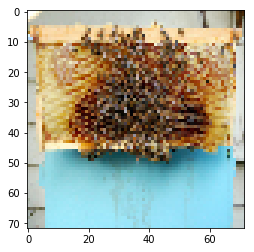

In [13]:
plt.imshow(arr_lr[7])

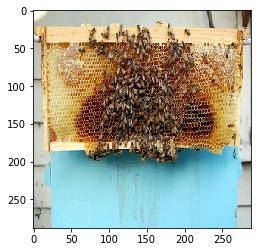

In [14]:
plt.imshow(arr_hr[7])

In [ ]:

img_lr=[]
img='image_lr'
img_lr.append(read_image('{}.png'.format(img),72,72))

img_lr = np.array(img_lr, np.float32)/255
img_lr.shape

In [ ]:

img_hr=[]
img='image_lr'
img_hr.append(read_image('{}.png'.format(img),288,288))

img_hr = np.array(img_hr, np.float32)/255
img_hr.shape

In [15]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=0)(x)
    return Activation('relu')(x) if act else x

In [16]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

In [17]:
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, 
        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization(mode=0)(x)
    return Activation('relu')(x)

In [18]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=0)(x)
    return Activation('relu')(x)

In [19]:
arr_lr.shape

(19439, 72, 72, 3)

In [20]:
inp=Input(arr_lr.shape[1:])

x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

In [21]:
model=Model(inp,outp)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 72, 72, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 72, 72, 64)    15616       input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 72, 72, 64)    256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 72, 72, 64)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [22]:
vgg_inp=Input(arr_hr.shape[1:])

In [23]:
vgg_inp.shape

TensorShape([Dimension(None), Dimension(288), Dimension(288), Dimension(3)])

In [24]:

vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

In [25]:
for l in vgg.layers: l.trainable=False


In [26]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

In [ ]:

preproc_layer = Lambda(preproc)


In [27]:


# get the vgg output 
vgg_out_layer = vgg.get_layer('block2_conv2').output

# making model Model(inputs, outputs)
vgg_content = Model(vgg_inp, vgg_out_layer)

vgg_content.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
Total para

In [28]:


# this is the VGG model with the HR input
vgg_hr_image = vgg_content(vgg_inp)

# this is the upsampled network
vgg_it_op = vgg_content(outp)



In [29]:
vgg_hr_image.shape

TensorShape([Dimension(None), Dimension(144), Dimension(144), Dimension(128)])

In [30]:
vgg_it_op.shape

TensorShape([Dimension(None), Dimension(144), Dimension(144), Dimension(128)])

In [31]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

NameError: name 'TQDMNotebookCallback' is not defined

In [35]:
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg_hr_image, vgg_it_op])

In [ ]:
'''
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)


w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res



m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((arr_hr.shape[0], 1))



'''



In [36]:
sr_model = Model([inp, vgg_inp], loss)
sr_model.compile('adam', 'mse')

In [37]:
sr_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 72, 72, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 72, 72, 64)    15616       input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 72, 72, 64)    256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 72, 72, 64)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [39]:
targ = np.zeros((arr_hr.shape[0], 128))
targ.shape

(19439, 128)

In [42]:

K.set_value(sr_model.optimizer.lr, 1e-4)
sr_model.fit([arr_lr, arr_hr], targ, 16, 1)




Epoch 1/1
19439/19439 [==============================] - 2138s - loss: 113644.4296  


In [43]:
K.set_value(sr_model.optimizer.lr, 1e-3)
sr_model.fit([arr_lr, arr_hr], targ, 16, 1)


Epoch 1/1
19439/19439 [==============================] - 2096s - loss: 85722.6642  


In [45]:


top_model = Model(inp, outp)



In [51]:
top_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 72, 72, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 72, 72, 64)    15616       input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 72, 72, 64)    256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 72, 72, 64)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [46]:
p = top_model.predict(arr_lr[10:11])

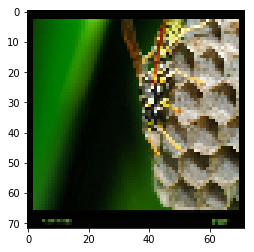

In [47]:
plt.imshow(arr_lr[10].astype('uint8'));

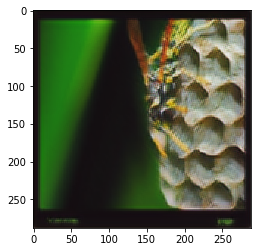

In [48]:
plt.imshow(p[0].astype('uint8'));

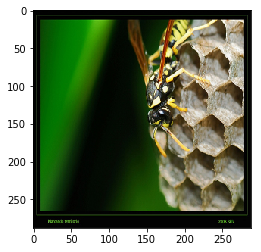

In [49]:
plt.imshow(arr_hr[10].astype('uint8'));

In [54]:


top_model.save_weights('sr_final.h5')




In [59]:
sr_model.save_weights('sr_main_model.h5')

In [ ]:
def save_model(model):    
    json_string = model.to_json()
    open('model_resnet.json', 'w').write(json_string)
    model.save_weights('final_model_weight.h5', overwrite=True)        



def load_model():
    model = model_from_json(open('model_finetune.json').read())
    model.load_weights('weights_finetune.h5')
    #model.compile(optimizer=rmsprop, loss='mse')
    return model    



In [60]:
from IPython.display import FileLink, FileLinks
FileLink('sr_main_model.h5')

/output/sr_main_model.h5